<a href="https://colab.research.google.com/github/sv650s/springboard/blob/master/2019_08_03_bootstrap_analysis_for_GRU_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use bootstraping to test statistical signifiance of our models

In our previous [notebook](https://github.com/sv650s/sb-capstone/blob/master/2019_08_02_biGRU_1layer_random_embedding_vs_pretrained.ipynb) where we compared the difference between pre-trained embeddings and random embeddings for 1 layer bidirectional GRUs we saw that the precision for class 2 was 34% in our base mode (random embedding) compared to 30% in the pargram model

We will use p-value to see if the difference in precision is statistically significant

Base mode - 1 layer bidirectional GRU with Attention using random embeddings
Pargram mode - 1 layer bidirectional GRU with Attetion using pre-trained paragram embeddings

Our *hypothesis* is that the base model produceses better precision for class 2 than paragrm model

I used 2 methods to do this:
* bootstrap paragram model predictions to see how likely it would be to produce the same precision as our base model - in hind sight this test is probably not valid because it does not account for variability of the precision of the base model as we are only bootstraping the paragram model predictions (but the code is included here anyways)
* using permutation method to get the p-value for predictions in both models to see how likely it is to generate the difference we saw in precisions in our GRU prototypes

**Conclusion**

p-value for generated the 4% difference in our precision for class 2 was around 10%. This is a borderline result - we cannot say it's definitive that one model is better than the other however, the likelihood that the difference is generated due to randomness is also rather low (~10% chance).


Code for our custom models are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)




In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np

# load from our custom modules
import util.keras_util as ku
import util.dict_util as du


report = pd.read_csv(f'{DRIVE_DIR}/reports/2019-08-03-dl_prototype-report.csv', quotechar="'")


base = report[report.model_name == 'biGRU_1layer_attention']
paragram = report[report.model_name == 'biGRU_1layer_attention-paragram']

DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv'
data = pd.read_csv(DATA_FILE)

# number of times we will sample
SAMPLE_ITERATIONS = 5000

Using TensorFlow backend.


## Reload our training data so we can create bootstrap samples




In [3]:
FEATURE_COLUMN = "review_body"
LABEL_COLUMN = "star_rating"

X_train, X_test, y_train, y_test, t, max_sequence_length = ku.preprocess_file(data, FEATURE_COLUMN, LABEL_COLUMN, 0.99)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 3 to 3
Data columns (total 24 columns):
accuracy                 1 non-null float64
classification_report    1 non-null object
confusion_matrix         1 non-null object
description              1 non-null object
embedding                1 non-null float64
evaluate_time_min        1 non-null float64
file                     1 non-null object
fpr                      1 non-null object
loss                     1 non-null float64
max_sequence_length      1 non-null float64
model_file               1 non-null object
model_name               1 non-null object
network_history_file     1 non-null object
predict_time_min         1 non-null float64
roc_auc                  1 non-null object
status                   1 non-null object
status_date              1 non-null object
test_examples            1 non-null float64
test_features            1 non-null float64
tokenizer_file           1 non-null object
tpr                      1 non-

### Reload our models so we can use them to do predictions later

In [0]:
import keras
from keras.layers import CuDNNGRU
from util.keras_util import AttentionLayer


In [6]:
base_model = keras.models.load_model(base.model_file.values[0], 
                                     custom_objects={'AttentionLayer': AttentionLayer})
base_predicted = base_model.predict(X_test, verbose=1)
base_predicted_unencoded = ku.unencode(base_predicted)
y_test_unencoded = ku.unencode(y_test)
base_predicted_unencoded[:5]

W0804 22:06:35.001941 140053671044992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 22:06:35.026881 140053671044992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 22:06:36.458085 140053671044992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 22:06:36.459074 140053671044992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 22:06:36.469124

28011/28011 [==============================] - 19s 688us/step


[5, 5, 5, 5, 5]

In [7]:
paragram_model = keras.models.load_model(paragram.model_file.values[0], 
                                     custom_objects={'AttentionLayer': AttentionLayer})
paragram_predicted = paragram_model.predict(X_test, verbose=1)
paragram_predicted_unencoded = ku.unencode(paragram_predicted)
paragram_predicted_unencoded[:5]

28011/28011 [==============================] - 1s 40us/step


[5, 5, 5, 1, 5]

## Bootstrap method

Here we will use the predictions for the paragram model and create bootstrap samples with replacement. For each bootstrap sample, we will create a classification report and extract the class 2 precision to create our distribution.

Once we have our distribution of class 2 precision from the paragram model, we will look at how likely it is to generate a precision that is equal or above the precision we saw from the our base model

In [0]:
import numpy as np
from sklearn.metrics import classification_report


def bootstrap_classification_report(predictions: np.ndarray,
                                    truths: np.ndarray,
                                    sample_size: int,
                                    ) -> dict:
  """
  Create bootstrap replicates classification report based on sample_size

  Parameters
  ----------
  :predictions: ndarray of predictions
  :truths: ndarray of truths
  :sample_size: number of samples with replacement 

  Return
  ------
  classfication report dictionary
  """
  sample_size = min(sample_size, len(predictions))
  indexes = np.random.choice(np.arange(sample_size), sample_size)
  truth_replicates = [truths[i] for i in indexes]
  prediction_replicates = [predictions[i] for i in indexes]
  return classification_report(truth_replicates,
                               prediction_replicates,
                               output_dict=True)


  


In [9]:
# Create bootstrap replicate is the class 2 precision

cr_df = pd.DataFrame()
for i in range(SAMPLE_ITERATIONS):
  cr = bootstrap_classification_report(paragram_predicted_unencoded,
                                      y_test_unencoded,
                                      len(paragram_predicted_unencoded))
  d = du.add_dict_to_dict({}, cr)
  cr_df = cr_df.append(d, ignore_index=True)
cr_df.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.705869,0.652361,0.768937,3934.0,0.123754,0.304703,0.077645,1919.0,0.314154,0.352826,0.283123,2536.0,0.306690,0.412710,0.244008,4631.0,0.834728,0.762809,0.921620,14991.0,0.672522,0.457039,0.497082,0.459067,28011.0,0.633492,0.620914,0.672522,28011.0
1,0.704116,0.653177,0.763673,3931.0,0.123288,0.289225,0.078341,1953.0,0.307073,0.341498,0.278953,2599.0,0.314646,0.410140,0.255222,4596.0,0.834841,0.765570,0.917894,14932.0,0.669701,0.456793,0.491922,0.458817,28011.0,0.632562,0.618919,0.669701,28011.0
2,0.701717,0.659518,0.749686,3979.0,0.120018,0.271287,0.077053,1778.0,0.308610,0.351969,0.274763,2635.0,0.307127,0.408092,0.246212,4752.0,0.829071,0.755800,0.918074,14867.0,0.666274,0.453309,0.489333,0.453157,28011.0,0.628467,0.614392,0.666274,28011.0
3,0.708870,0.663938,0.760324,3947.0,0.117204,0.293501,0.073222,1912.0,0.293713,0.328692,0.265462,2490.0,0.330579,0.430475,0.268313,4696.0,0.832153,0.760566,0.918616,14966.0,0.671522,0.456504,0.495435,0.457187,28011.0,0.634028,0.621339,0.671522,28011.0
4,0.696412,0.649218,0.751005,3980.0,0.115649,0.270321,0.073560,1944.0,0.308423,0.341137,0.281435,2537.0,0.320757,0.429950,0.255794,4703.0,0.835963,0.762995,0.924362,14847.0,0.670201,0.455441,0.490724,0.457231,28011.0,0.631861,0.618511,0.670201,28011.0


count    5000.000000
mean        0.302756
std         0.020892
min         0.224206
25%         0.288678
50%         0.302594
75%         0.316876
max         0.373518
Name: 2_precision, dtype: float64


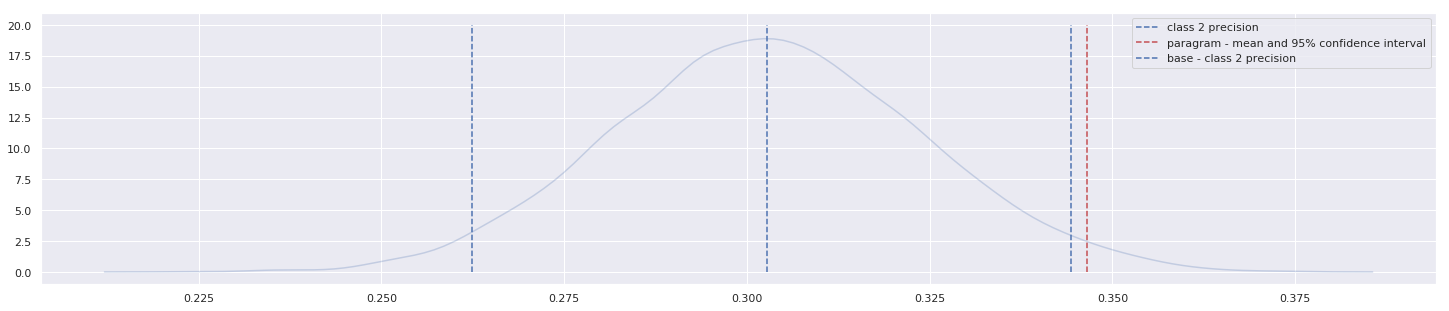

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline
sns.set()

base_cr_dict = du.add_dict_to_dict({}, json.loads(base.classification_report.values[0]))


precision2 = cr_df["2_precision"]
paragram_ci = np.percentile(precision2.to_list(), [2.5, 97.5])

print(precision2.describe())

f, a = plt.subplots(1, 1, figsize=(25, 5))
sns.kdeplot(cr_df["2_precision"].values, alpha=0.25, color="b", cumulative=False)
plt.vlines(precision2.mean(), ymin=0, ymax=20.0, linestyle="--", color="b", label='paragram')
plt.vlines(base_cr_dict["2_precision"], ymin=0, ymax=20.0, linestyle="--", color="r", label='base')
for i in paragram_ci:
  plt.vlines(i, ymin=0, ymax=20.0, linestyle="--", color="b")
a.legend(['class 2 precision', 'paragram - mean and 95% confidence interval', 'base - class 2 precision'])


In [13]:
print(f'p-value: {len(cr_df[cr_df["2_precision"] > base_cr_dict["2_precision"]]) / SAMPLE_ITERATIONS}')

p-value: 0.0194


# Bootstrap Conclusion

It looks like that our p-value is 1.4%

Genreally we consider p-value of 5% or lower as statistically significant. In this case, there is less than a 1.4% chance that the precision results that we saw in our test that we would generate a difference of ~4% in precision for class 2. This means that the class 2 precision difference between our base model and the paragram model is statistically significant.

We can confidently say that the base model is more accurate in predicting class 2 reviews


Again, this test may not valid since we are not accounting for variations in class 2 precision for the base model and only using the precision result from our notebook

# Permutation Method

Our null hypothesis is that the difference in class 2 precision (~4%) is due to chance.

In order to test this, we are going to combine the predictions from both models, permuate and split into 2 groups. The statistic we will use the difference in precision between the 2 groups.

In [0]:
# to test the null hypothesis, we permutate between the 2 groups and see what the difference
# in class 2 precision is


def permutate(truths, predictions):

  indexes = np.random.permutation(len(truths))
  indexes1 = indexes[:len(truths) // 2]
  indexes2 = indexes[len(truths) // 2:]

  # create our permutation sets
  truth1 = [truths[i] for i in indexes1]
  predictions1 = [predictions[i] for i in indexes1]
  truth2 = [truths[i] for i in indexes2]
  predictions2 = [predictions[i] for i in indexes2]

  class2_precision1 = du.add_dict_to_dict({}, classification_report(truth1, predictions1, output_dict=True))["2_precision"]
  class2_precision2 = du.add_dict_to_dict({}, classification_report(truth2, predictions2, output_dict=True))["2_precision"]

  class2_precision_diff = class2_precision2 - class2_precision1

  return class2_precision_diff





  



In [27]:
truth_concat = np.hstack((y_test_unencoded, y_test_unencoded))
predictions_concat = np.hstack((base_predicted_unencoded, paragram_predicted_unencoded))

diffs = np.empty(SAMPLE_ITERATIONS)
for i in range(SAMPLE_ITERATIONS):
  diffs[i] = permutate(truth_concat, predictions_concat)

diffs[:5]

array([ 0.01019701, -0.00447367, -0.04377028,  0.05954767, -0.01515663])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


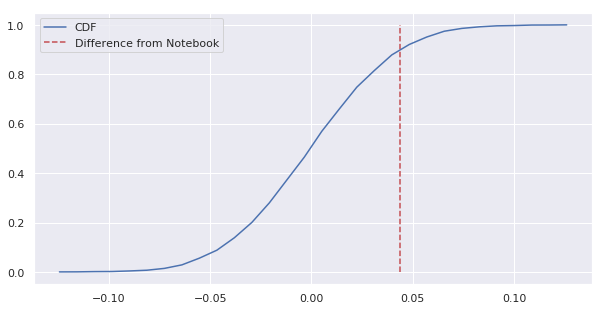

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline
sns.set()

base_class2_precision = du.add_dict_to_dict({}, json.loads(base.classification_report.values[0]))["2_precision"]
paragram_class2_precision = du.add_dict_to_dict({}, json.loads(paragram.classification_report.values[0]))["2_precision"]

class2_diff = base_class2_precision - paragram_class2_precision


f, a = plt.subplots(figsize=(10, 5))
num_bins = 30
# plot histogram
# plt.hist(diffs, bins=num_bins, color='b', alpha=0.25, density=True)

# plot CDF
counts, bin_edges = np.histogram(diffs, bins=num_bins, normed=True) 
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.vlines(class2_diff, ymin=0, ymax=1.0, color='r', linestyles='--')
a.legend(['CDF', 'Difference from Notebook'])


# plt.hist(diffs, bins=num_bins, density=True)

In [29]:
print(f'P-value: {np.sum(diffs >= class2_diff) / len(diffs)}')

P-value: 0.1008


# Conclusion

Blue line is the CDF of the difference in class 2 precision from our test of 10k iterations. Red line is the difference we saw in our previous notebook. The intersect between these 2 lines tells us the p-value of the difference.

The p-value for the difference in class 2 precision we saw between the 2 models is about 10%. This means that if it was by chance, we would expect that the difference to be what we saw 10% of the time. Generally, we consider 5% as statistically significant and 10% is borderline which means our results may not be conclusive enough to say that our base model is definitely better than the paragram model.